In [1]:
import numpy as np
print('Numpy version:', np.__version__)

import pandas as pd
print('Pandas version:', pd.__version__)

import matplotlib as mpl
print('Matplotlib version:', mpl.__version__)
import matplotlib.pyplot as plt

import seaborn as sns
print('Seaborn version:', sns.__version__)

from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold

import pickle

from sklearn.cluster import KMeans

Numpy version: 1.23.5
Pandas version: 1.5.2
Matplotlib version: 3.6.2
Seaborn version: 0.12.1


In [2]:
import warnings
warnings.filterwarnings('ignore')

t-SNE is very time-consuming so we have to take about 8000 stratified samples and perform t-SNE visualization using them instead of full dataset

In [3]:
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=1024503) #, random_state=1024503

In [4]:
n_components = 2
datasets_options = [f'opt{x}' for x in range(1, 11)] + ['gv']
pps = [10, 50, 100]

In [9]:
# !!! time expensive
# calculating t-SNE values for all possible datasets
recalc_tsne_coords = False
if recalc_tsne_coords:
    tsnes_df = pd.DataFrame([], columns=['tsne_x', 'tsne_y', 'y', 'rec_indexes', 'preproc_opt', 'perplexity'])
    for i, opt in enumerate(datasets_options):
        df = pd.read_csv(f'datasets/processed/bank-train-encoded-{opt}.csv', comment='#')
        _, idxs = list(kfold.split(df.drop(columns=[col for col in ['y', 'duration'] if col in df.columns]), df['y']))[0]
        for j, pp in enumerate(pps):
            print(f'Computing variant: dataset option: {opt}, perplexity value: {pp}. Current tsnes_df length: {len(tsnes_df)}')
            tsne = TSNE(n_components=n_components, perplexity=pp, random_state=1028503, init='pca', learning_rate='auto', n_jobs=3)
            #ind = opt + '-' + str(pp)
            tmp = pd.concat([
                    pd.DataFrame(tsne.fit_transform(df.drop(columns=[col for col in ['y', 'duration'] if col in df.columns]).iloc[idxs]), columns=['tsne_x', 'tsne_y']),
                    pd.Series(df['y'].iloc[idxs].to_numpy(), name='y'),
                    pd.Series(idxs, name='rec_indexes'),
                    pd.Series([opt]*len(idxs), name='preproc_opt'),
                    pd.Series([pp]*len(idxs), name='perplexity')
                ], axis=1
            )
            tsnes_df = pd.concat([tsnes_df, tmp])
            #tsnes[ind]['tsne'] = tsne.fit_transform(df.drop(columns=[col for col in ['y', 'duration'] if col in df.columns]).iloc[idxs])
            #tsnes[ind]['y'] = df['y'].iloc[idxs]
            #tsnes[ind]['indexes'] = idxs
    tsnes_df.to_csv('models/tsne_clustering.csv', index=False)
else:
    tsnes_df = pd.read_csv('models/tsne_clustering.csv')

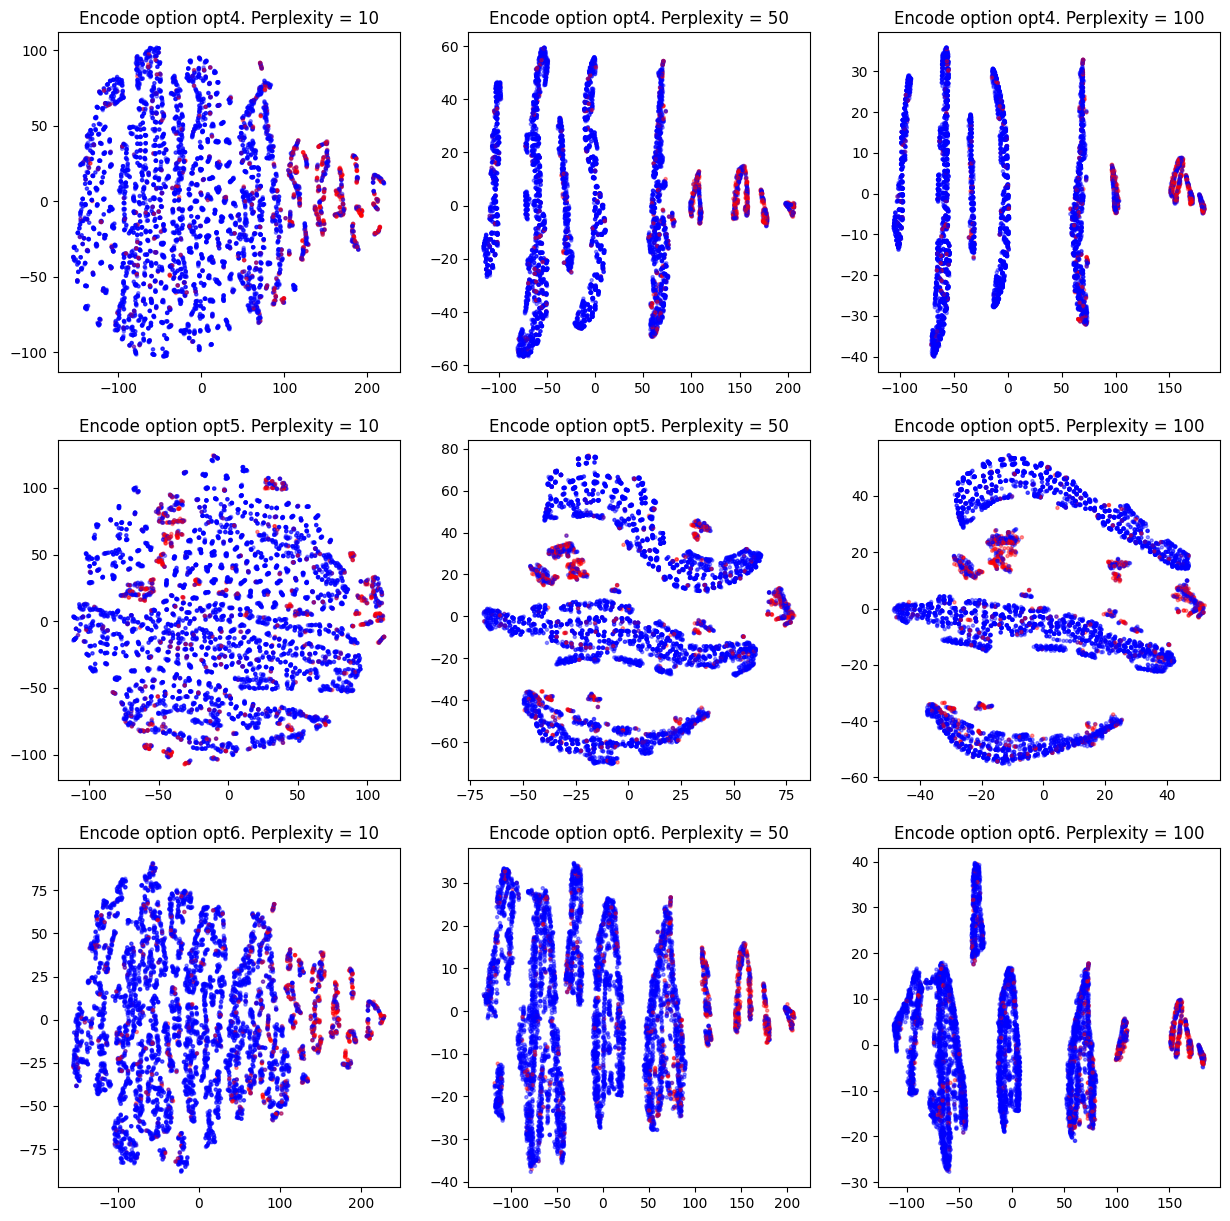

In [25]:
plot_options = ['opt4', 'opt5', 'opt6']
subplot_size = (5, 5) # (width, height)

plots_cols = len(pps)
plots_rows = len(plot_options)
fig, axs = plt.subplots(plots_rows, plots_cols, figsize=(subplot_size[0]*plots_cols, subplot_size[1]*plots_rows))

for i, opt in enumerate(plot_options):
    for j, pp in enumerate(pps):
        tsne_res = tsnes_df[(tsnes_df['preproc_opt'] == opt) & (tsnes_df['perplexity'] == pp)]
        if len(tsne_res) > 0:
            axs[i, j].scatter(tsne_res['tsne_x'], tsne_res['tsne_y'], c=tsne_res['y'], s=5, cmap='bwr', alpha=0.4)
            axs[i, j].set_title(f'Encode option {opt}. Perplexity = {pp}');

We chose opt4 preprocessing (but we could choose opt6 as well) with perplexity value 100 for further analysis as it gives us well-defined and conveniently located clusters. We'll have to deal with x-axis only to get clusters estimates

In [56]:
pp = 100
opt = 'opt4'
y = [-40, 40]
delimiters = [
    (-120, -120),
    (-80, -80),
    (-45, -45),
    (-22, -22),
    (30, 30),
    (85, 85),
    (130, 130),
    (190, 190),
]

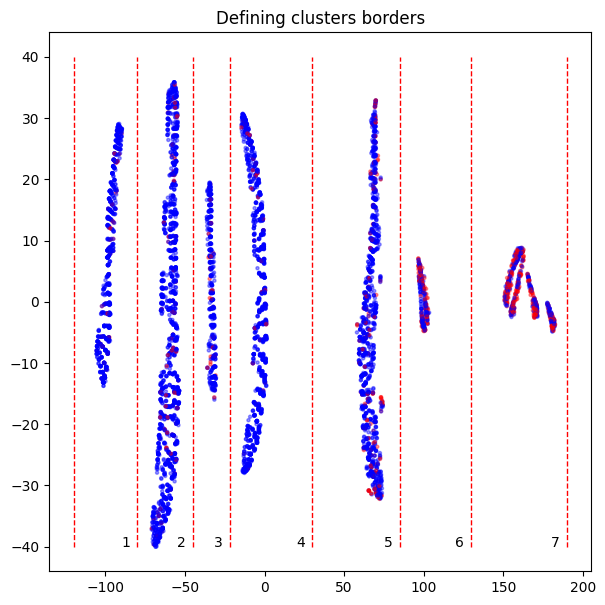

In [57]:
# check chosen t-SNE visualization
tsne_res = tsnes_df[(tsnes_df['preproc_opt'] == opt) & (tsnes_df['perplexity'] == pp)]
if len(tsne_res) > 0:
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    ax.scatter(tsne_res['tsne_x'], tsne_res['tsne_y'], c=tsne_res['y'], s=5, cmap='bwr', alpha=0.4)

    for i, x in enumerate(delimiters):
        ax.plot(x, y, 'r--', lw=1)
        if i > 0:
            ax.annotate(str(i), xy=(x[0]-10, y[0]))
    ax.set_title('Defining clusters borders');

We can calculate the ratio of positive outcome in each cluster.  
Clusters with x > 30 seem to have more positive values density than clusters with x < 30

In [63]:
# Comparing probability of positive label in each cluster
pos_probas = np.zeros(shape=(len(delimiters)-1, 2)) # column 0 for probability, column 1 for number of observations
ref_points = {}
for i in range(1, len(delimiters)):
    x_prev = delimiters[i-1][0]
    x_cur = delimiters[i][0]
    temp = tsne_res[(tsne_res['tsne_x'] > x_prev) & (tsne_res['tsne_x'] < x_cur)]
    pos_probas[i-1, 0] = temp['y'].mean()
    pos_probas[i-1, 1] = len(temp)
    if ref_points.get(i, None) is None:
        ref_points[i] = temp['rec_indexes'].iloc[0]
    #print('Range ({}; {}) ({} observations): {:.3f}'.format(x_prev, x_cur, len(temp), temp.mean()))

In [64]:
# number of observations in cluster
print('Positive probabilities:', np.round(pos_probas[:, 0]*100, 1))
print('Observations number   :', pos_probas[:, 1])

Positive probabilities: [ 5.9  5.2  6.2  3.4 11.4 33.5 51. ]
Observations number   : [ 899. 1950.  608. 1363. 1510.  266.  612.]


Based on probabilities above we can join clusters with indexes 0-3 as low-probability cluster and clusters with indexes 4-5 as medium-probability (but we can treat them separate as well as their probabilies differ significantly).  
Now we can take one sample from each cluster as reference points to train clustering algorithm (say KMeans)  
Let's try to build 4 clusters: low, low-medium, high-medium and high probability

In [65]:
ref_points

{1: 28, 2: 7, 3: 8, 4: 37, 5: 2, 6: 328, 7: 139}

In [78]:
init_kmeans_centr = [ref_points[1], ref_points[5], ref_points[6], ref_points[7]]
init_kmeans_centr

[28, 2, 328, 139]

In [79]:
n_clusters = 4
df = pd.read_csv(f'datasets/processed/bank-train-encoded-{opt}.csv', comment='#')
km_clustering = KMeans(n_clusters=n_clusters, init=df.drop(columns=['y']).loc[init_kmeans_centr])

In [80]:
km_clustering.fit(df.drop(columns=['y']))

KMeans(init=     age       job   marital  education   default   housing      loan  \
28    50 -0.112315 -0.117542  -0.015772  0.000117 -0.027129 -0.001524   
2     46 -0.049966 -0.106173  -0.009927  0.000117  0.021907 -0.001524   
328   30  0.257693 -0.117542  -0.009927  0.000117  0.021907 -0.001524   
139   51 -0.049966 -0.117542   0.232972  0.000117  0.021907 -0.001524   

     contact     month  day_of_week  campaign  pdays  previous  poutcome  \
28         1 -0.069575     0.014815         3     -1         0 -0.276437   
2          1 -0.598223    -0.104080         2     -1         0 -0.276437   
328        1 -0.112177     0.014815         1     -1         0 -0.276437   
139        1 -0.112177     0.014815         1     10         1  2.576719   

     emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  
28            1.4          93.444          -36.1      4.965       5228.1  
2            -1.8          92.893          -46.2      1.244       5099.1  
328          -2.9          92.963          -40.8      1.262       5076.2  
139          -1.7          94.055          -39.8      0.702       4991.6  ,
       n_clusters=4)

In [81]:
df['cluster'] = km_clustering.predict(df.drop(columns=['y']))
df.head(7)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,cluster
0,50,-0.496110,0.254735,-0.015772,0.000117,-0.027129,-0.001524,0,-0.598223,0.065041,...,-1,0,-0.276437,1.1,93.994,-36.4,4.860,5191.0,0,0
1,51,-0.368015,-0.117542,-0.009927,0.000117,-0.027129,-0.001524,0,-0.598223,-0.104080,...,-1,0,-0.276437,1.1,93.994,-36.4,4.858,5191.0,0,0
2,46,-0.049966,-0.106173,-0.009927,0.000117,0.021907,-0.001524,1,-0.598223,-0.104080,...,-1,0,-0.276437,-1.8,92.893,-46.2,1.244,5099.1,0,1
3,46,0.154788,0.254735,0.232972,0.000117,0.021907,-0.001524,0,-0.112177,-0.104080,...,-1,0,-0.276437,1.4,94.465,-41.8,4.961,5228.1,0,0
4,25,-0.368015,0.254735,0.005154,0.000117,-0.027129,-0.001524,1,-0.598223,0.065041,...,-1,0,-0.276437,-1.8,92.893,-46.2,1.266,5099.1,1,1
5,52,-0.049966,-0.117542,-0.339898,0.000117,-0.027129,-0.001524,1,-0.598223,0.065041,...,-1,1,0.280533,-1.8,92.893,-46.2,1.266,5099.1,0,1
6,29,-0.049966,0.254735,0.232972,0.000117,0.021907,-0.001524,1,-0.112177,0.033534,...,-1,0,-0.276437,-2.9,92.963,-40.8,1.260,5076.2,0,2


Let's calculate probabilities for defined clusters and compare them against initial cluster probabilities

In [112]:
df.groupby(by=['cluster'])['y'].agg(['count', 'mean'])

,count,mean
cluster,,
0,19365,0.049832
1,5980,0.124582
2,1151,0.350130
3,2335,0.486081


These probabilities match almost perfect with probabilities we saw in test fold  
Now we can estimate financial results using clustering. We consider that if cluster is chosen to process in marketing campaign then all customers from this cluster will be called. Thus we will have neither true negatives nor false positives. All clients in cluster will be either true or false positive. If we refuse to include any cluster in campaign then its values changes respectively: true positives become false negatives and false positives become true negatives  
Based on financial info we can organize financial results per call in the way corresponding to confusion matrix:  
- true negatives = 0 as we don't call them
- true positives = margin per positive
- false positives = margin per negative as we call them but they refuse to open deposit
- false negatives = lost profit as we don't call them but they could open deposit (in fact we can take this factor into account or not in which case it will be 0)

In [83]:
margin_per_positive = 26.3 - 0.5 # for positive (customer opens deposit) = interest sum - call cost
margin_per_negative = -0.5 # for negative (customer doesn't open deposit) = - call cost

margin = np.array([0, margin_per_negative, -margin_per_positive, margin_per_positive]).reshape(2, 2)  
margin

array([[  0. ,  -0.5],
       [-25.8,  25.8]])

In [85]:
c_f = {}
for i in range(df['cluster'].max()+1):
    c_f[i] = np.zeros(shape=(2, 2))
    temp = df[df['cluster'] == i]
    c_f[i][1, 1] = temp['y'].sum()
    c_f[i][0, 1] = len(temp) - c_f[i][1, 1]
c_f

{0: array([[    0., 18400.],
        [    0.,   965.]]),
 1: array([[   0., 5235.],
        [   0.,  745.]]),
 2: array([[  0., 748.],
        [  0., 403.]]),
 3: array([[   0., 1200.],
        [   0., 1135.]])}

In [102]:
# returns confusion matrixes for all clusters based on decision about including them into campaign or not:
# if cluster is included == all customers in it are marked by model as positives and will be called => positives consider as True Positive while negatives as False Positives
# if cluster is excluded == all customers in it are marked as negatives and no customer in it will be called => positives consider as False Negatives and negatives as True Negatives
def get_clusters_cm(base_cm, include):
    if len(base_cm) != len(include):
        raise ValueError('Arguments have different lengths')
    result = base_cm.copy()
    for key, cm in base_cm.items():
        if not include[key]:
            result[key] = np.hstack((cm[:, 1].reshape(-1, 1), cm[:, 0].reshape(-1, 1)))
    return result

In [116]:
def get_finres(base_cm, include, margin):
    finres = 0
    for key, cm in get_clusters_cm(base_cm, include).items():
        finres += (cm * margin).sum()
    return finres

In [104]:
include_clusters = {0: True, 1: False, 2: False, 3: True}

In [105]:
get_clusters_cm(c_f, include_clusters)

{0: array([[    0., 18400.],
        [    0.,   965.]]),
 1: array([[5235.,    0.],
        [ 745.,    0.]]),
 2: array([[748.,   0.],
        [403.,   0.]]),
 3: array([[   0., 1200.],
        [   0., 1135.]])}

In [106]:
df_test = pd.read_csv(f'datasets/processed/bank-test-encoded-{opt}.csv', comment='#')

In [107]:
df_test['cluster'] = km_clustering.predict(df_test.drop(columns=['y']))
df_test.sample(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,cluster
9551,42,-0.496110,-0.117542,-0.015772,0.000117,-0.027129,-0.001524,1,-0.210152,0.033534,...,-1,0,-0.276437,1.4,93.918,-42.7,4.963,5228.1,0,0
8473,36,-0.496110,-0.117542,-0.451380,0.000117,-0.027129,-0.001524,1,-0.598223,0.065041,...,-1,0,-0.276437,-1.8,92.893,-46.2,1.327,5099.1,0,1
2473,37,-0.368015,-0.117542,0.005154,0.000117,0.021907,-0.001524,1,-0.210152,-0.104080,...,-1,0,-0.276437,-2.9,92.469,-33.6,0.944,5076.2,0,2
9487,54,0.154788,-0.117542,0.005154,0.000117,0.021907,-0.001524,1,-0.069575,-0.014867,...,-1,0,-0.276437,1.4,93.444,-36.1,4.966,5228.1,0,0
6361,38,-0.285862,-0.117542,-0.339898,0.000117,-0.027129,-0.001524,1,-0.112177,0.014815,...,2,3,2.576719,-1.7,94.055,-39.8,0.761,4991.6,1,3
1917,18,1.166204,0.254735,-0.015772,0.000117,0.021907,-0.001524,0,-0.100297,0.014815,...,13,2,2.576719,-1.1,94.767,-50.8,1.049,4963.6,1,3
11917,30,0.154788,-0.117542,0.232972,0.000117,-0.027129,-0.001524,0,-0.598223,0.014815,...,-1,0,-0.276437,1.1,93.994,-36.4,4.857,5191.0,0,0
8243,40,-0.496110,-0.117542,-0.339898,0.000117,0.021907,-0.001524,0,-0.112177,0.014815,...,-1,0,-0.276437,-1.7,94.055,-39.8,0.702,4991.6,0,3
7484,45,-0.496110,-0.117542,-0.339898,0.000117,-0.027129,-0.001524,0,-0.598223,-0.014867,...,-1,0,-0.276437,1.1,93.994,-36.4,4.857,5191.0,0,0
5805,48,0.154788,0.254735,0.232972,0.000117,0.021907,-0.001524,1,-0.069575,0.065041,...,-1,0,-0.276437,1.4,93.444,-36.1,4.968,5228.1,0,0


Now we'll check if the probabilities on test set are same as on train set...

In [108]:
for i in range(df_test['cluster'].max()+1):
    print('Cluster {}, positive probability: {:.1f}'.format(i, df_test[df_test['cluster']==i]['y'].mean()*100))

Cluster 0, positive probability: 4.5
Cluster 1, positive probability: 13.6
Cluster 2, positive probability: 37.3
Cluster 3, positive probability: 49.7


...and they are. So clustering technique seems correct and works as we expected  
Calculating confusion matrixes for each cluster based on same assumptions

In [109]:
c_f_test = {}
for i in range(df_test['cluster'].max()+1):
    c_f_test[i] = np.zeros(shape=(2, 2))
    temp = df_test[df_test['cluster'] == i]
    c_f_test[i][1, 1] = temp['y'].sum()
    c_f_test[i][0, 1] = len(temp) - c_f_test[i][1, 1]
c_f_test

{0: array([[   0., 7951.],
        [   0.,  374.]]),
 1: array([[   0., 2207.],
        [   0.,  347.]]),
 2: array([[  0., 321.],
        [  0., 191.]]),
 3: array([[  0., 486.],
        [  0., 480.]])}

In [111]:
include_test = {0: False, 1: False, 2: False, 3: True}
finres = 0
for key, cm in get_clusters_cm(c_f_test, include_test).items():
    finres += (cm * margin).sum()
finres

-11388.600000000002

In [113]:
include_test = {0: False, 1: False, 2: True, 3: True}
finres = 0
for key, cm in get_clusters_cm(c_f_test, include_test).items():
    finres += (cm * margin).sum()
finres

-1693.5000000000036

In [114]:
include_test = {0: False, 1: True, 2: True, 3: True}
finres = 0
for key, cm in get_clusters_cm(c_f_test, include_test).items():
    finres += (cm * margin).sum()
finres

15108.2

In [115]:
include_test = {0: True, 1: True, 2: True, 3: True}
get_finres(c_f_test, include_test, margin)

30431.100000000002

In [121]:
income_per_positive = 26.3
cost_per_call_to_income_ratio = 0.05 # => cost_per_call = cost_per_call_to_income_ratio * income_per_positive
margin_per_positive = income_per_positive * (1 - cost_per_call_to_income_ratio) # for positive (customer opens deposit) = interest sum - call cost
margin_per_negative = -income_per_positive * cost_per_call_to_income_ratio # for negative (customer doesn't open deposit) = - call cost

margin = np.array([0, margin_per_negative, -margin_per_positive, margin_per_positive]).reshape(2, 2)  
margin

array([[  0.   ,  -1.315],
       [-24.985,  24.985]])

In [147]:
def get_margin_matrix(pos_income, cost_per_call_ratio):
    pos_margin = pos_income * (1 - cost_per_call_ratio)
    neg_margin = -pos_income * cost_per_call_ratio
    return np.array([0, neg_margin, -pos_margin, pos_margin]).reshape(2, 2)

In [148]:
get_margin_matrix(income_per_positive, 0.05)

array([[  0.   ,  -1.315],
       [-24.985,  24.985]])

In [144]:
# Creating data for calling customers from all clusters
include_test = {0: True, 1: True, 2: True, 3: True}
all_calls = None
for x in np.arange(0, 1.01, 0.01):
    pos_margin = income_per_positive * (1 - x)
    neg_margin = -income_per_positive * x # customer doesn't open deposit = - call cost
    margin = np.array([0, neg_margin, -pos_margin, pos_margin]).reshape(2, 2)
    if all_calls is None:
        all_calls = np.array([x, np.max((0, get_finres(c_f_test, include_test, margin)))])
    else:
        all_calls = np.vstack((all_calls, np.array([x, np.max((0, get_finres(c_f_test, include_test, margin)))])))

In [145]:
# Creating data for calling customers from all clusters except 0 (low-probability) 
include_test = {0: False, 1: True, 2: True, 3: True}
clusters_123_calls = None
for x in np.arange(0, 1.01, 0.01):
    pos_margin = income_per_positive * (1 - x)
    neg_margin = -income_per_positive * x # customer doesn't open deposit = - call cost
    margin = np.array([0, neg_margin, -pos_margin, pos_margin]).reshape(2, 2)
    if clusters_123_calls is None:
        clusters_123_calls = np.array([x, np.max((0, get_finres(c_f_test, include_test, margin)))])
    else:
        clusters_123_calls = np.vstack((clusters_123_calls, np.array([x, np.max((0, get_finres(c_f_test, include_test, margin)))])))

In [154]:
print('Breakeven point for "Call all customers" strategy is at cost_per_call = ', all_calls[all_calls[:, 1].argmin(), 0]*100, '% of income per positive')
print('Breakeven point for "Call customers if probability of positive > 10%" strategy is at cost_per_call = 'clusters_123_calls[clusters_123_calls[:, 1].argmin(), 0]*100, '% of income per positive')

0.12
0.18


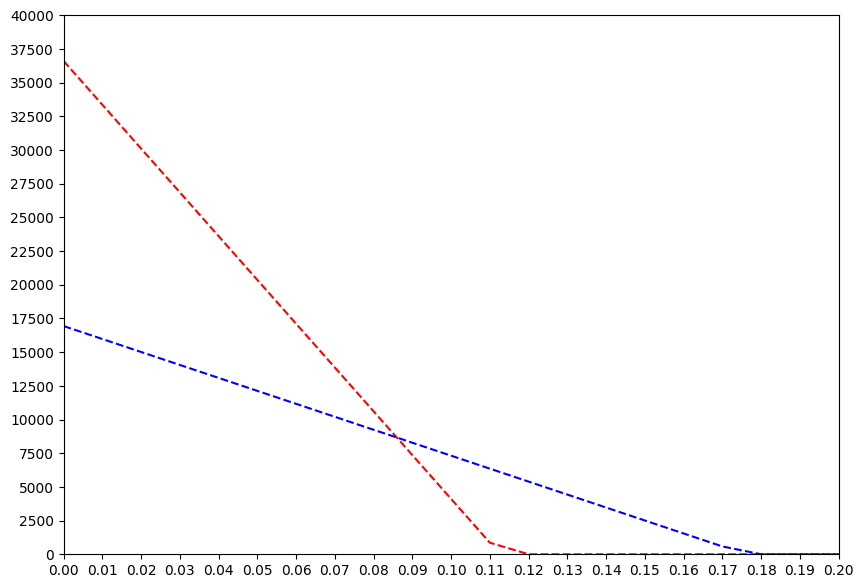

In [159]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.plot(all_calls[:, 0], all_calls[:, 1], 'r--')
ax.plot(clusters_123_calls[:, 0], clusters_123_calls[:, 1], 'b--')
ax.set_xbound(lower=0, upper=0.2)
ax.set_xticks(np.arange(0, 0.21, 0.01))
ax.set_ybound(lower=0)
ax.set_yticks(np.arange(0, 40001, 2500));